In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import cv2
import gc
from tqdm import tqdm
from PIL import Image
from glob import glob
%matplotlib inline
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

In [2]:
all_xray_df = pd.read_csv('/kaggle/input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x))
all_xray_df['Binary Labels'] = all_xray_df['Finding Labels'].map(lambda x: 0.0 if x == 'No Finding' else 1.0)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Binary Labels
99030,00026194_009.png,Atelectasis,9,26194,11,F,AP,3056,2544,0.139000,0.139000,NaN,../input/data/images_011/images/00026194_009.png,1.0
109444,00029777_000.png,Infiltration,0,29777,52,F,PA,2021,2021,0.194311,0.194311,NaN,../input/data/images_012/images/00029777_000.png,1.0
36107,00009526_000.png,No Finding,0,9526,62,F,PA,2048,2500,0.168000,0.168000,NaN,../input/data/images_005/images/00009526_000.png,0.0


In [3]:
print('Before sampling...')
label_counts = all_xray_df['Binary Labels'].value_counts()
print(label_counts)

print('After sampling...')
all_xray_df = all_xray_df.sample(22000, random_state=25)
label_counts = all_xray_df['Binary Labels'].value_counts()
print(label_counts)
all_xray_df.sample(3)

Before sampling...
0.0    60361
1.0    51759
Name: Binary Labels, dtype: int64
After sampling...
0.0    11764
1.0    10236
Name: Binary Labels, dtype: int64


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Binary Labels
35203,00009297_017.png,Atelectasis|Effusion|Fibrosis,17,9297,66,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_005/images/00009297_017.png,1.0
71926,00017717_004.png,No Finding,4,17717,42,M,PA,2992,2991,0.143,0.143,NaN,../input/data/images_008/images/00017717_004.png,0.0
89139,00022133_003.png,No Finding,3,22133,70,M,AP,3056,2544,0.139,0.139,NaN,../input/data/images_010/images/00022133_003.png,0.0


In [4]:
images = list(all_xray_df['path'])
labels = list(all_xray_df['Binary Labels'].map(lambda x: [x]))
train_img, val_img, train_label, val_label = train_test_split(images, labels, 
                                   test_size = 0.2, 
                                   random_state = 7,
                                   stratify = labels)
print('train:', len(train_img), '\nvalidation:', len(val_img))

train: 17600 
validation: 4400


In [5]:
class Net(nn.Module):
    def __init__(self, model):
        super(Net, self).__init__()
        self.resnet_layer = nn.Sequential(*list(model.children())[:-1])
        self.Linear_layer = nn.Sequential(nn.Linear(1280, 4096), 
                                              nn.ReLU(),
                                              nn.Dropout(0.2),
                                              nn.Linear(4096, 2048),
                                              nn.ReLU(),
                                              nn.Dropout(0.2),
                                              nn.Linear(2048, 1024),
                                              nn.ReLU(),
                                              nn.Dropout(0.2),
                                              nn.Linear(1024, 512),
                                              nn.ReLU(),
                                              nn.Linear(512, 1))
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = self.resnet_layer(x)
        x = x.view(x.size(0), -1)
        x = self.Linear_layer(x)
        x = self.out(x)
        return x

In [6]:
class my_set(Dataset):
    def __init__(self,Data,Label,transform=None):
        self.images = Data
        self.label = Label
        self.transform = transform
        
    def __getitem__(self, index):
        label = self.label[index]
        temp = cv2.imread(self.images[index])
        temp = np.array(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))
        #print(self.images[index])
        try:
          temp = (temp * 255).round().astype(np.uint8)
        except:
          print(self.images[index])
        img = Image.fromarray(temp)
        if self.transform:
          img = self.transform(img)
        label = torch.Tensor([label])
        label = label.to(torch.float)
        return img, label
        
    def __len__(self):
        return len(self.images)

my_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

In [7]:
model = models.efficientnet_v2_s(pretrained=True)
model = Net(model)
print(model)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


  0%|          | 0.00/82.7M [00:00<?, ?B/s]

Net(
  (resnet_layer): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.00

In [8]:
train = my_set(train_img, train_label, transform = my_transform)
trainloader = DataLoader(train, batch_size=8, shuffle=True, num_workers = 2)

val = my_set(val_img, val_label, transform = my_transform)
validloader = DataLoader(val, batch_size=8, shuffle=False, num_workers = 2)


valid_loss_min = np.Inf # track change in validation loss
criterion = nn.BCELoss()
#optimizer = torch.optim.SGD(params=model.parameters(), lr=0.0002, momentum = 0.9 ,weight_decay=0.00002 )
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0002, weight_decay=0.00002 )
n_epochs = 10

train_ac = []
test_ac = []
t_loss = []
v_loss = []

In [9]:
print('CUDA:',torch.version.cuda)
device = torch.device("cuda")
model = model.to(device)
print(device)
gc.collect()
torch.cuda.empty_cache()

CUDA: 11.3
cuda


In [10]:
def training_loop(model):
    for epoch in tqdm(range(1, n_epochs+1)):
        train_loss = 0.0
        valid_loss = 0.0
        print('running epoch: {}'.format(epoch))
        model.train()
        train_correct = 0
        train_total = 0
        for data, target in trainloader:
            target = target.squeeze(1)
            # move tensors to GPU if CUDA is available
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            train_total += target.size(0)
            predicted = (output>0.5).float()
            train_correct += (predicted == target).sum().item()
            del data
            gc.collect()
            torch.cuda.empty_cache()

        # validate the model
        model.eval()
        valid_correct = 0
        valid_total = 0
        for data, target in validloader:
            target = target.squeeze(1)
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            valid_total += target.size(0)
            predicted = (output>0.5).float()
            valid_correct += (predicted == target).sum().item()
            del data
            gc.collect()
            torch.cuda.empty_cache()
        # calculate average losses
        train_loss = train_loss/len(trainloader.dataset)
        valid_loss = valid_loss/len(validloader.dataset)
        t_loss.append(train_loss)
        v_loss.append(valid_loss)
        train_ac.append(100 * train_correct / train_total)
        test_ac.append(100 * valid_correct / valid_total) 

        print('Train Loss: {}'.format(train_loss))
        print('Validation Loss: {}'.format(valid_loss))
        print('Train Accuracy: {}'.format(100 * train_correct / train_total))
        print('Validation Accuracy: {}'.format(100 * valid_correct / valid_total))

In [11]:
training_loop(model)

  0%|          | 0/10 [00:00<?, ?it/s]

running epoch: 1


 10%|█         | 1/10 [24:51<3:43:44, 1491.66s/it]

Train Loss: 0.6500930540670048
Validation Loss: 0.6096516620029103
Train Accuracy: 63.67045454545455
Validation Accuracy: 68.38636363636364
running epoch: 2


 20%|██        | 2/10 [48:16<3:12:03, 1440.44s/it]

Train Loss: 0.6247120946781202
Validation Loss: 0.6157441590590911
Train Accuracy: 67.02272727272727
Validation Accuracy: 68.56818181818181
running epoch: 3


 30%|███       | 3/10 [1:12:10<2:47:42, 1437.52s/it]

Train Loss: 0.6172589494423433
Validation Loss: 0.6030878310311925
Train Accuracy: 67.45454545454545
Validation Accuracy: 68.79545454545455
running epoch: 4


 40%|████      | 4/10 [1:35:53<2:23:11, 1431.89s/it]

Train Loss: 0.6094746304506605
Validation Loss: 0.6203848006237637
Train Accuracy: 68.2215909090909
Validation Accuracy: 68.72727272727273
running epoch: 5


 50%|█████     | 5/10 [1:58:49<1:57:39, 1411.83s/it]

Train Loss: 0.6064339609308677
Validation Loss: 0.5967337927493183
Train Accuracy: 68.74431818181819
Validation Accuracy: 69.36363636363636
running epoch: 6


 60%|██████    | 6/10 [2:21:39<1:33:10, 1397.62s/it]

Train Loss: 0.5999032775854523
Validation Loss: 0.6014326161688024
Train Accuracy: 69.30681818181819
Validation Accuracy: 69.06818181818181
running epoch: 7


 70%|███████   | 7/10 [2:44:12<1:09:08, 1382.79s/it]

Train Loss: 0.5949944415756248
Validation Loss: 0.5946547511490908
Train Accuracy: 69.75568181818181
Validation Accuracy: 69.18181818181819
running epoch: 8


 80%|████████  | 8/10 [3:07:19<46:08, 1384.31s/it]  

Train Loss: 0.5911797783726995
Validation Loss: 0.6333478203415871
Train Accuracy: 69.92613636363636
Validation Accuracy: 68.72727272727273
running epoch: 9


 90%|█████████ | 9/10 [3:31:13<23:19, 1399.93s/it]

Train Loss: 0.5890137472003698
Validation Loss: 0.596137827038765
Train Accuracy: 70.125
Validation Accuracy: 69.31818181818181
running epoch: 10


100%|██████████| 10/10 [3:55:02<00:00, 1410.28s/it]

Train Loss: 0.5824064177342436
Validation Loss: 0.5942079882188277
Train Accuracy: 70.75568181818181
Validation Accuracy: 69.75


In [12]:
test_correct = 0
test_total = 0
pred_label = []
pred_for_roc_curve = []
for data, target in validloader:
    target = target.squeeze(1)
    data, target = data.to(device), target.to(device)
    out = model(data)
    predicted = (out>0.5).float()
    pred_label.extend(predicted.tolist())
    pred_for_roc_curve.extend(out.tolist())
    test_correct += (predicted == target).sum().item()
    test_total += target.size(0)
    del data
    gc.collect()
    torch.cuda.empty_cache()
print('Testing Auccracy: {}'.format((100 * test_correct / test_total)))
acu = (100 * test_correct / test_total)

Testing Auccracy: 69.20454545454545


In [13]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
model_confusion_matrix = confusion_matrix(val_label, pred_label)
model_confusion_matrix

array([[1680,  673],
       [ 682, 1365]])

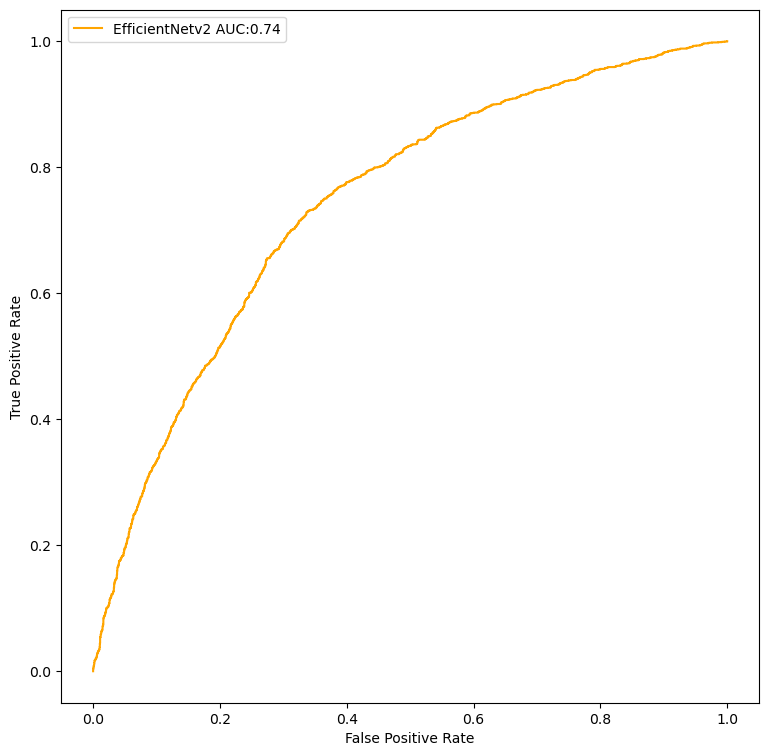

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score as acc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
fpr, tpr, thresholds = roc_curve(val_label, pred_for_roc_curve)
c_ax.plot(fpr, tpr, color='orange', label = 'EfficientNetv2 AUC:%0.2f'  % (auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.savefig("plot1.png")

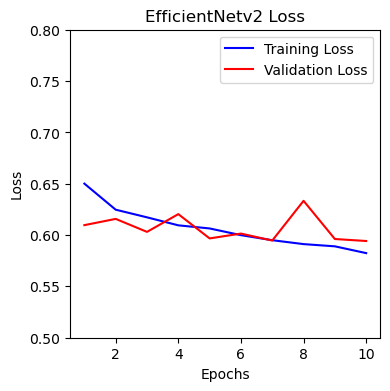

In [15]:
fig, c_ax = plt.subplots(1,1, figsize = (4, 4))
y = np.arange(1, n_epochs + 1)
c_ax.plot(y, t_loss, color='blue', label = 'Training Loss')
c_ax.plot(y, v_loss, color='red', label = 'Validation Loss')
c_ax.legend()
c_ax.set_xlabel('Epochs')
c_ax.set_title('EfficientNetv2 Loss')
plt.ylim([0.5, 0.8])
c_ax.set_ylabel('Loss')
plt.savefig("plot2.png")